In [1]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import random
import textwrap
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

In [2]:
df_with_rqtl_and_language = pd.read_pickle("../skype_scraping/pkl/df_with_rqtl_and_language.pkl")
df_conversation_turns = df_with_rqtl_and_language[
    (df_with_rqtl_and_language['conversation_tag'] != 'delete') & 
    (df_with_rqtl_and_language['conversation_tag'] != 'private')
]
rand_index = random.randint(0, len(df_conversation_turns)-6)
display(df_conversation_turns[rand_index:rand_index+5])

,conversation_id,turns,date,conversation_tag,turn_id,prompt,response,message_tag,trimmed_prompt,label_rq,prob_rq,label_tl,prob_tl,detected_language
404,109,9,2023-07-05,,000109008,En el siguiente texto hay 49 palabras. Explica...,"En el siguiente texto hay 25 palabras, no 49. ...",hallucination,en el siguiente texto hay 49 palabras. explica...,question,0.588740,test,0.928030,es
405,109,9,2023-07-05,,000109009,Qué instrucción tengo que darte para que cuent...,Una posible instrucción que podrías darme para...,hallucination,que instruccion tengo que darte para que cuent...,request,0.525726,test,0.645691,es
411,112,1,2023-07-05,,000112001,"what is the meaning of the word ""berlanguiano""?","The word ""berlanguiano"" is used to qualify som...",,"what is the meaning of the word "" berlanguiano ""?",question,0.909553,learn,0.890595,en
414,114,2,2023-07-05,,000114001,Who are the most typical users of Facebook now...,"According to some statistics, Facebook has mor...",,who are the most typical users of facebook now...,question,0.879700,learn,0.952953,en
415,114,2,2023-07-05,,000114002,What are the main differences between content ...,Facebook and Instagram are both popular social...,,what are the main differences between content ...,question,0.875754,learn,0.961957,en


In [3]:
prompt_sample = df_conversation_turns.sample(1)['prompt'].values[0]
wrapped_message = textwrap.fill(prompt_sample, width=120)
print(wrapped_message)

¿Cómo se puede traducir “vergüenza ajena” al inglés?


In [4]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
print(nli_model.classification_head.out_proj)
print(nli_model.config.id2label)

Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
zs_classifier = pipeline("zero-shot-classification", model=nli_model, tokenizer=nli_tokenizer, device=0)

In [6]:
sample_record = df_conversation_turns.sample(1)
full_sample = f"😎 {sample_record['prompt'].values[0]} \n🤖 {sample_record['response'].values[0]}"
wrapped_message = textwrap.fill(full_sample, width=120)
# candidate_labels = ["coding", "language", "music", "philosophy", "science", "finance", "politics", "history", "art", "business", "grammar", "text", "technology"]
candidate_labels = [
    "Language and writing",
    "Coding",
    "Technology",
    "Science",
    "Culture and Entertainment",
    "Finance and Business",
    "General Knowledge",
    "Philosophy and Discussion"
]
sentence = [full_sample]
result = zs_classifier(sentence, candidate_labels, multi_label=False)
clear_output(wait=True) # remove library warnings
wrapped_content = textwrap.fill(result[0]["sequence"], width=120)
print(f'Text:\n{wrapped_content}')

print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')
print(f'Sorted labels: {result[0]["labels"]}')
print(f'full scores: {[f"{score:.2f}" for score in result[0]["scores"]]}')

Text:
😎 Help me make this sentence more catchy: “time to make a choice and don’t look back. Where do you put the chips?”  🤖
Sure, I can help you make this sentence more catchy. Here are some possible ways to rephrase it:  •  No turning back
now. Where do you stack the chips?  •  It's now or never. Where do you place your bets?  •  The moment of truth. Where
do you put your money?  •  Make your move and don't regret it. Where do you drop the chips?  •  It's crunch time. Where
do you lay down the chips?
Label: Language and writing (score: 0.38)
Sorted labels: ['Language and writing', 'Science', 'General Knowledge', 'Coding', 'Philosophy and Discussion', 'Technology', 'Finance and Business', 'Culture and Entertainment']
full scores: ['0.38', '0.12', '0.11', '0.09', '0.09', '0.08', '0.08', '0.06']


### Prompt statistics

Code inspired by this article:
https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327

In [38]:
df_turns_en = df_conversation_turns[(df_conversation_turns['detected_language'] == 'en')]

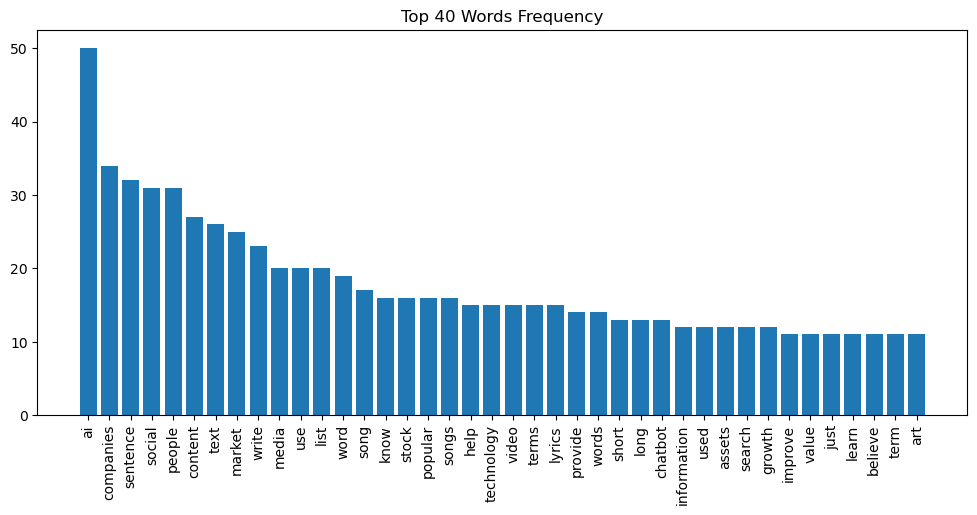

In [55]:
# Vectorize the text data to count word occurrences
vectorizer = CountVectorizer(stop_words='english')
data = df_turns_en['prompt'].tolist()
X_counts = vectorizer.fit_transform(data)

# Sum up the counts of each word in the vocabulary
word_counts = X_counts.toarray().sum(axis=0)
word_freq = [(word, word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

excluded_words = ['make', 'want', 'don', 'like', 'good', 'com']
# Filter out the excluded words
word_freq = [wf for wf in word_freq if wf[0] not in excluded_words]

# Histogram with the most frequent words
top_n_words = 40
words = [wf[0] for wf in word_freq[:top_n_words]]
counts = [wf[1] for wf in word_freq[:top_n_words]]
plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title(f"Top {top_n_words} Words Frequency")
plt.show()

In [56]:
word_freq

[('ai', 50),
 ('companies', 34),
 ('sentence', 32),
 ('social', 31),
 ('people', 31),
 ('content', 27),
 ('text', 26),
 ('market', 25),
 ('write', 23),
 ('media', 20),
 ('use', 20),
 ('list', 20),
 ('word', 19),
 ('song', 17),
 ('know', 16),
 ('stock', 16),
 ('popular', 16),
 ('songs', 16),
 ('help', 15),
 ('technology', 15),
 ('video', 15),
 ('terms', 15),
 ('lyrics', 15),
 ('provide', 14),
 ('words', 14),
 ('short', 13),
 ('long', 13),
 ('chatbot', 13),
 ('information', 12),
 ('used', 12),
 ('assets', 12),
 ('search', 12),
 ('growth', 12),
 ('improve', 11),
 ('value', 11),
 ('just', 11),
 ('learn', 11),
 ('believe', 11),
 ('term', 11),
 ('art', 11),
 ('support', 11),
 ('explain', 11),
 ('title', 11),
 ('humorous', 10),
 ('better', 10),
 ('business', 10),
 ('based', 10),
 ('following', 10),
 ('does', 10),
 ('free', 10),
 ('include', 10),
 ('similar', 9),
 ('xyz', 9),
 ('company', 9),
 ('try', 9),
 ('financial', 9),
 ('suggest', 9),
 ('crypto', 9),
 ('coinbase', 9),
 ('quote', 9),
 ('i

In [57]:
df = df_turns_en[['prompt']].copy()
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
# excluded_words = ['make', 'want', 'don', 'like', 'good'] #DEFINED PREVIOUSLY

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words and word not in excluded_words])
    return text

# Apply preprocessing to the text data
df['clean_text'] = df['prompt'].apply(preprocess_text)
display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,prompt,clean_text
0,Help me rephrase this tagline by giving me a f...,help rephras taglin give altern inspir innov fun
1,Give me a creative sentence for a closed ended...,give creativ sentenc close end poll survey cho...
2,Can you make them more humorous?,humor
3,"Give me a few more, without making reference t...",give without make refer champion fight
4,Can you make them relate to a technology-relat...,relat technolog relat poll
...,...,...
759,Where there any news in Spain in particular th...,news spain particular could relat tweet
760,what is the current list of countries where St...,current list countri starlik internet servic a...
761,Make a list of keywords that were very popular...,list keyword popular social media frequent use...
762,Can you write a comparative review of Grammarl...,write compar review grammar vs quillbot well h...


In [58]:
# Transform the cleaned text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
print(X_tfidf.shape)

(334, 1416)


K-MEANS

In [59]:
# Apply K-Means with a predetermined number of clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

# Get the cluster assignments
labels_kmeans = kmeans.labels_+1
df['cluster_kmeans'] = labels_kmeans
display(df)

,prompt,clean_text,cluster_kmeans
0,Help me rephrase this tagline by giving me a f...,help rephras taglin give altern inspir innov fun,4
1,Give me a creative sentence for a closed ended...,give creativ sentenc close end poll survey cho...,5
2,Can you make them more humorous?,humor,5
3,"Give me a few more, without making reference t...",give without make refer champion fight,1
4,Can you make them relate to a technology-relat...,relat technolog relat poll,4
...,...,...,...
759,Where there any news in Spain in particular th...,news spain particular could relat tweet,4
760,what is the current list of countries where St...,current list countri starlik internet servic a...,4
761,Make a list of keywords that were very popular...,list keyword popular social media frequent use...,6
762,Can you write a comparative review of Grammarl...,write compar review grammar vs quillbot well h...,1


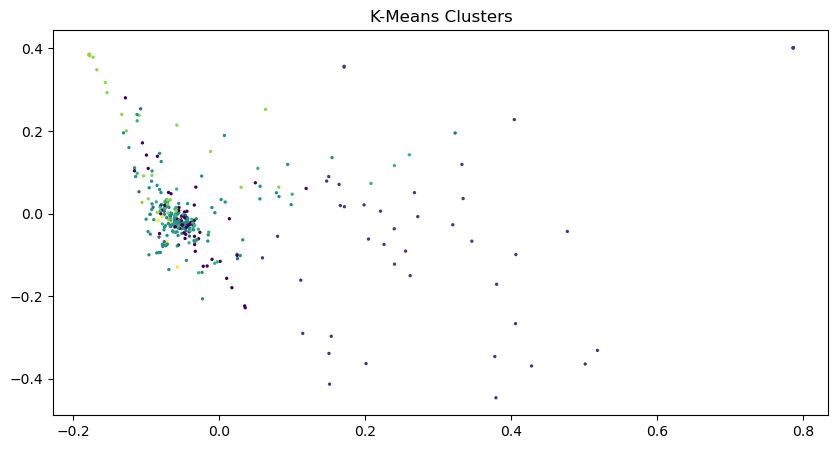

In [60]:
# Function to plot clusters
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=2)
    plt.title(title)
    plt.show()

# Reduce dimensions to 2 for visualization
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())
# Visualize clusters
plot_clusters(X_pca, labels_kmeans, 'K-Means Clusters')

Word frequency histograms per cluster:

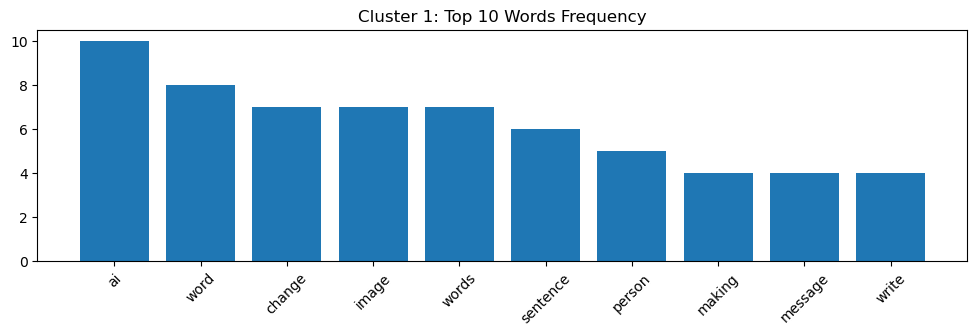

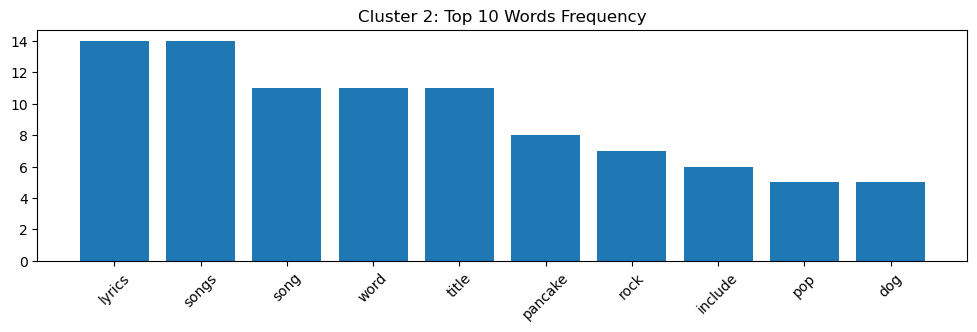

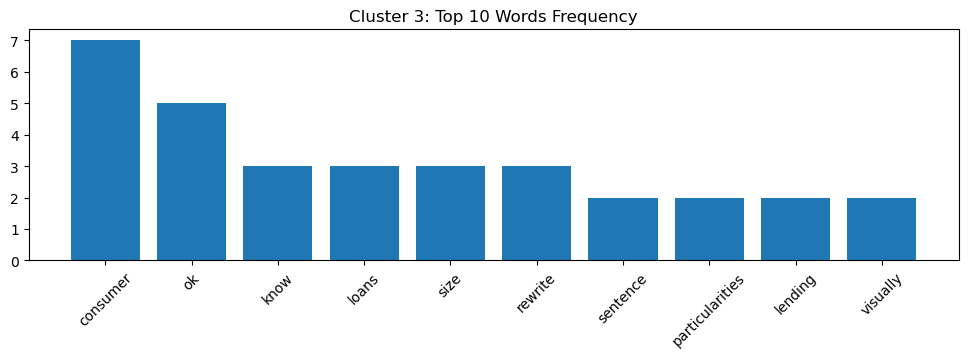

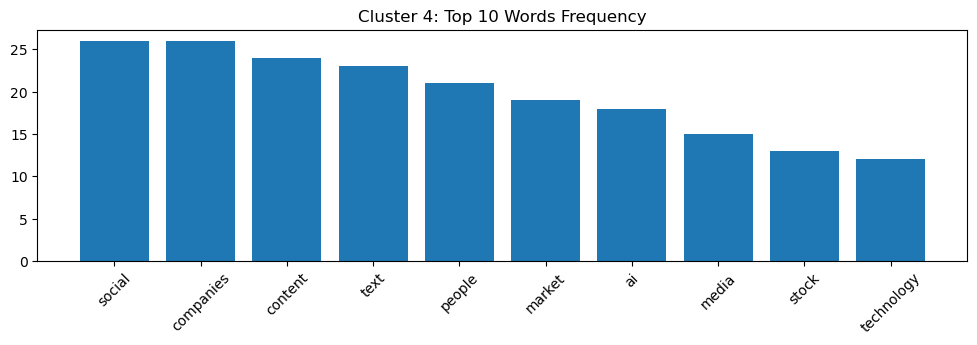

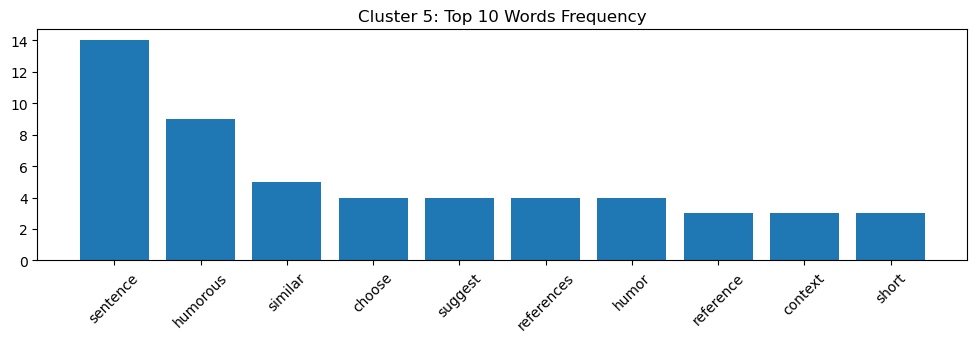

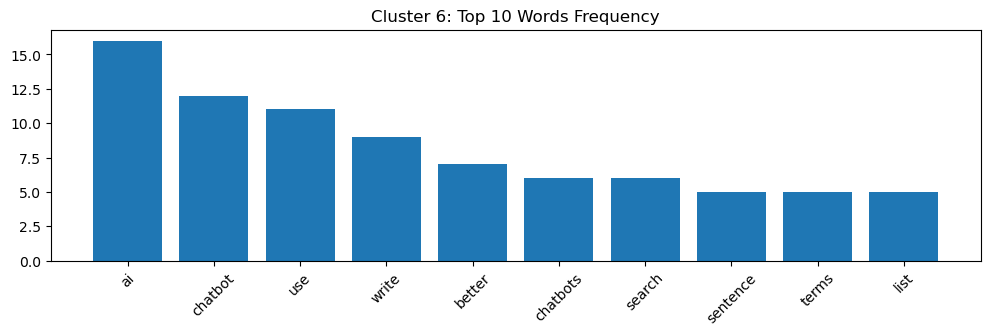

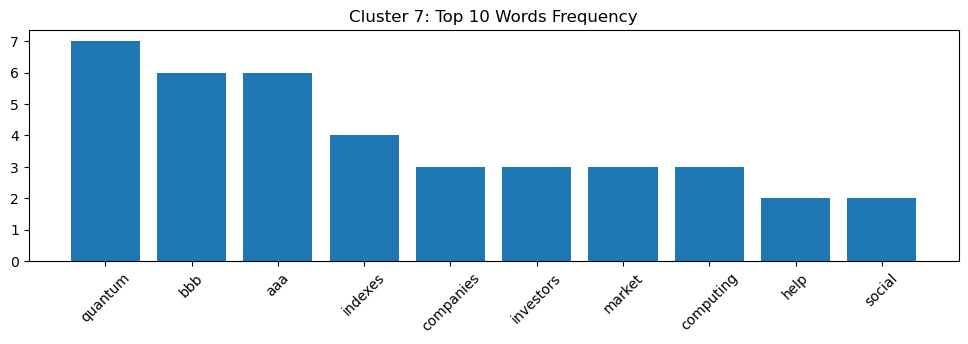

In [63]:
# Get the raw word count matrix for each cluster
for cluster_id in range(1, num_clusters+1):
    # Filter the rows corresponding to the current cluster
    cluster_data = df[df['cluster_kmeans'] == cluster_id]['prompt']
    
    # Vectorize the text data for this cluster
    cluster_counts = vectorizer.transform(cluster_data)
    cluster_word_counts = cluster_counts.toarray().sum(axis=0)
    
    # Compute word frequencies for the current cluster
    cluster_word_freq = [(word, cluster_word_counts[idx]) for word, idx in vectorizer.vocabulary_.items()]
    cluster_word_freq = sorted(cluster_word_freq, key=lambda x: x[1], reverse=True)

    # Filter out the excluded words (for histograms only)
    histogram_excluded_words = ['make', 'want', 'don', 'like', 'good', 'com']
    cluster_word_freq = [wf for wf in cluster_word_freq if wf[0] not in histogram_excluded_words]
    
    # Select top N terms for plotting
    top_n_words = 10
    words = [wf[0] for wf in cluster_word_freq[:top_n_words]]
    counts = [wf[1] for wf in cluster_word_freq[:top_n_words]]
    
    # Plot the histogram for the current cluster
    plt.figure(figsize=(12, 3))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f"Cluster {cluster_id}: Top {top_n_words} Words Frequency")
    plt.show()

_____________________

Classification for full dataframe (prompts only):

In [20]:
# Initialize an empty list to store the results
results = []

# Iterate over each record in the dataframe with a progress bar
for index, row in tqdm(df_conversation_turns.iterrows(), total=len(df_conversation_turns)):
    # full_sample = f"😎 {row['prompt']} \n🤖 {row['response']}"
    sentence = [row['prompt']]
    result = zs_classifier(sentence, candidate_labels, multi_label=False)
    scores_dict = {label: score for label, score in zip(result[0]["labels"], result[0]["scores"])}
    record_dict = row.to_dict()
    record_dict.update(scores_dict)
    record_dict['highest_score_label'] = result[0]["labels"][0]
    results.append(record_dict)

df_with_scores = pd.DataFrame(results)
display(df_with_scores)

  0%|          | 0/412 [00:00<?, ?it/s]

,conversation_id,turns,date,conversation_tag,turn_id,prompt,response,message_tag,trimmed_prompt,label_rq,...,detected_language,Culture and Entertainment,Philosophy and Discussion,Language and writing,Finance and Business,Coding,General Knowledge,Technology,Science,highest_score_label
0,2,12,2023-06-01,,000002001,Help me rephrase this tagline by giving me a f...,"Sure, I can help you with that. Here are some ...",,help me rephrase this tagline by giving me a f...,request,...,en,0.270439,0.158934,0.144536,0.101570,0.100906,0.088950,0.084762,0.049902,Culture and Entertainment
1,2,12,2023-06-01,,000002002,Give me a creative sentence for a closed ended...,Here are some creative sentences for a closed ...,,give me a creative sentence for a closed ended...,request,...,en,0.042876,0.043470,0.675428,0.036459,0.047962,0.050607,0.069690,0.033508,Language and writing
2,2,12,2023-06-01,,000002003,Can you make them more humorous?,"Sure, I can try to make them more humorous. He...",,can you make them more humorous?,question,...,en,0.346200,0.088690,0.156990,0.083957,0.104628,0.066891,0.112746,0.039896,Culture and Entertainment
3,2,12,2023-06-01,,000002004,"Give me a few more, without making reference t...","Okay, I can give you a few more sentences with...",,"give me a few more, without making reference t...",request,...,en,0.134821,0.114969,0.136302,0.076112,0.129078,0.217528,0.092411,0.098778,General Knowledge
4,2,12,2023-06-01,,000002005,Can you make them relate to a technology-relat...,"Sure, I can make them relate to a technology-r...",,can you make them relate to a technology - rel...,question,...,en,0.013670,0.011867,0.012568,0.016508,0.034646,0.029775,0.856716,0.024250,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,290,1,2023-10-09,,000290001,Make a list of keywords that were very popular...,Here is a list of keywords that were very popu...,,make a list of keywords that were very popular...,request,...,en,0.161329,0.141851,0.085574,0.137503,0.105176,0.103245,0.145829,0.119495,Culture and Entertainment
408,293,2,2024-01-30,,000293001,Can you write a comparative review of Grammarl...,"Sure, I can try to write a comparative review ...",,can you write a comparative review of grammarl...,request,...,en,0.042652,0.043421,0.725798,0.030891,0.032694,0.055838,0.047804,0.020901,Language and writing
409,293,2,2024-01-30,,000293002,Are there any other similar writing tools avai...,"Yes, there are many other online writing tools...",,are there any other similar writing tools avai...,question,...,en,0.097358,0.087480,0.346662,0.098308,0.041423,0.093447,0.124844,0.110479,Language and writing
410,295,2,2024-09-05,,000295001,¿Cuándo es el próximo año jubilar lebaniego?,El próximo Año Jubilar Lebaniego comenzó el 16...,,¿ cuando es el proximo ano jubilar lebaniego?,question,...,es,0.165994,0.112594,0.410530,0.074129,0.045951,0.080096,0.064484,0.046222,Language and writing


In [21]:
df_with_scores.to_csv('df_with_scores.csv', index=False)